# CSCI 453 "Please Compile" Final Project

### Logan Zug, Ben Alrbright, Gavin Fry

In [1]:
# Start with all of the includes we'll need for the project...

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [3]:
# Begin...

In [4]:
df = pd.read_csv("reviews.csv")

In [5]:
df.drop(['unix_timestamp_created', 'unix_timestamp_updated'], axis=1, inplace=True)
df.dropna(inplace=True)

In [6]:
df.rename(columns={'weighted_vote_score': 'helpful_score', 'voted_up': 'is_recommended', 'votes_up': 'upvotes'}, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452657 entries, 0 to 1455441
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   steamid             1452657 non-null  int64  
 1   appid               1452657 non-null  int64  
 2   is_recommended      1452657 non-null  bool   
 3   upvotes             1452657 non-null  int64  
 4   votes_funny         1452657 non-null  int64  
 5   helpful_score       1452657 non-null  float64
 6   playtime_forever    1452657 non-null  int64  
 7   playtime_at_review  1452657 non-null  int64  
 8   num_games_owned     1452657 non-null  int64  
 9   num_reviews         1452657 non-null  int64  
 10  review              1452657 non-null  object 
dtypes: bool(1), float64(1), int64(8), object(1)
memory usage: 123.3+ MB


# Gavin

In [8]:
df.head()

,steamid,appid,is_recommended,upvotes,votes_funny,helpful_score,playtime_forever,playtime_at_review,num_games_owned,num_reviews,review
0,76561198795470246,599080,True,1,0,0.52381,400,400,230,2,Minus the quiet communication (other players s...
1,76561199026616351,599080,True,0,0,0.00000,745,192,19,8,yeah.
2,76561198259829110,599080,True,0,0,0.00000,1572,1572,50,4,Playing this game was the most fun I have ever...
3,76561198123742442,599080,True,0,0,0.00000,3684,2001,119,1,I love the interactive lore and story telling
4,76561198998908891,599080,True,0,0,0.00000,249,249,31,10,gg


## Feature-Scaling

In [56]:
# Set df2 = df1 and clean up outliers
df2 = df

# Take a sample of 5000 reviews with a random seed 1...
data = df2.sample(n=50, random_state = 1, replace = False)

# Instantiate the Label Encoder Object
label_encoder = LabelEncoder()

# Fit and transform the column
data['Individual'] = label_encoder.fit_transform(data['steamid'])

# Initialize scaler
min_max_scaler = MinMaxScaler()

# Put playtime_forever and playtime_at_review through the min_max_scaler to transforrm
data[['playtime_forever', 'playtime_at_review']] = min_max_scaler.fit_transform(data[['playtime_forever', 'playtime_at_review']])

# Multiply by 100 to get it as a percentage
data[['playtime_forever', 'playtime_at_review']] = 100 * data[['playtime_forever', 'playtime_at_review']]

In [57]:
data.head()

,steamid,appid,is_recommended,upvotes,votes_funny,helpful_score,playtime_forever,playtime_at_review,num_games_owned,num_reviews,review,Individual
793671,76561198390790543,702890,True,1,0,0.523810,12.027606,0.714848,13,15,This game very good. Epic Animation and BGM.,36
656897,76561198088070696,674020,False,3,0,0.527027,0.037725,0.055745,37,1,I just payed 28 dollars to sit in the main men...,17
582005,76561198058804757,653530,True,0,0,0.000000,2.678472,3.957896,136,11,What a videogame,10
815350,76561198007480123,712100,False,1,0,0.495679,7.476200,11.047350,91,3,I'm an old gamer from the 90s when computers f...,3
1356437,76561198050928417,955900,True,1,0,0.000000,4.125336,5.220357,62,1,Highly entertaining and makes time fly by. Hav...,8


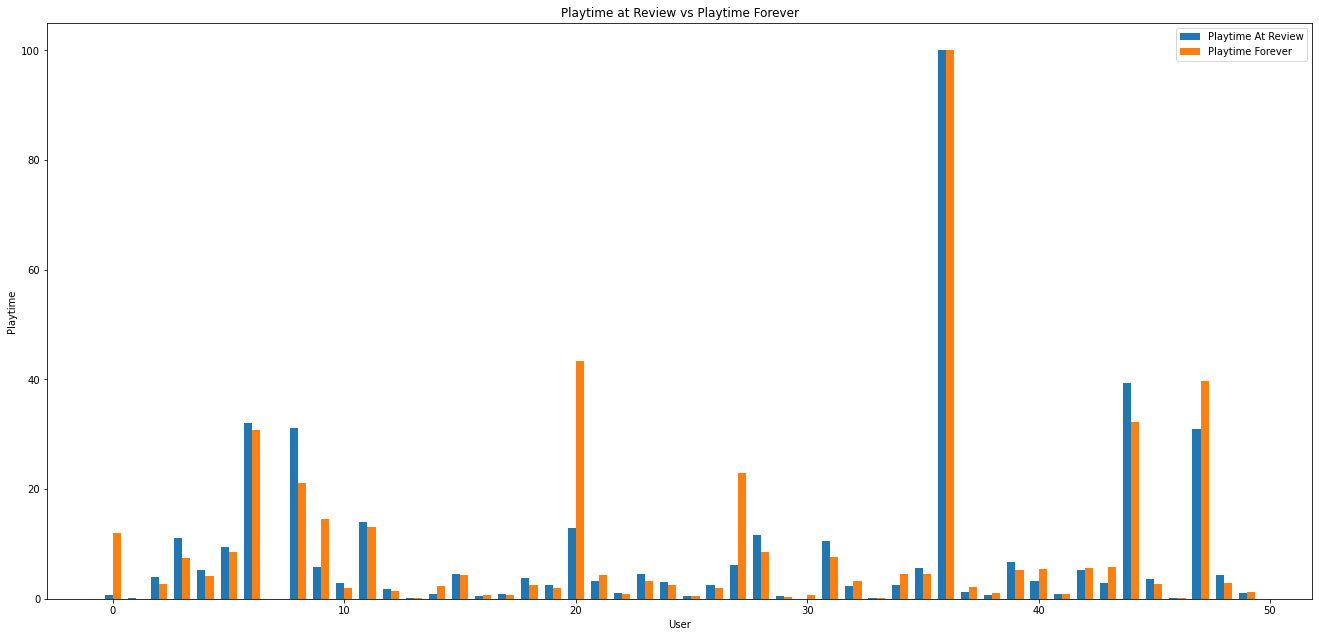

In [59]:
labels = data.Individual

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, data.playtime_at_review, width, label='Playtime At Review')
rects2 = ax.bar(x + width/2, data.playtime_forever, width, label='Playtime Forever')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Playtime')
ax.set_xlabel('User')
ax.set_title('Playtime at Review vs Playtime Forever')
ax.legend()

fig.tight_layout()
fig.set_size_inches(20.5, 10.5)

plt.show()

## Clustering

In [12]:
# Take the two columns we want from OG df...
df2 = df[["votes_funny", "helpful_score"]]

# Drop 0's
df2= df2[df2['votes_funny'] != 0]
df2= df2[df2['helpful_score'] != 0]

# Take a sample of 5000 reviews with a random seed 1...
data = df2.sample(n=5000, random_state = 1, replace = False)

# Determine the lower and upper range for votes_funny
q_lowFunny = data["votes_funny"].quantile(0.10)
q_hiFunny  = data["votes_funny"].quantile(0.90)

# Determine the lower and upper range for helpful....
q_lowHelpful = data["helpful_score"].quantile(0.10)
q_hiHelpful  = data["helpful_score"].quantile(0.90)

# Take the previously determined lower and upper and use them to filter the data into a new 
df_filtered = data[(data["votes_funny"] < q_hiFunny) & (data["votes_funny"] > q_lowFunny)]
df_filtered = data[(data["helpful_score"] < q_hiHelpful) & (data["helpful_score"] > q_lowHelpful)]

# Define number of clusters
num_clusters = 10
 
# Creating instance of PCA and transforming the data from df_filtered to fit PCA
pca = PCA()
data_pca = pca.fit_transform(df_filtered)

# Creating the PC columns within pca_df for use in clustering
pca_df = pd.DataFrame(data_pca,columns=['PC1','PC2'])

# Create and fit the KMeans model
km = KMeans(n_clusters=num_clusters)
km.fit(df_filtered)
 
# Predict the target variable
pred=km.predict(df_filtered)

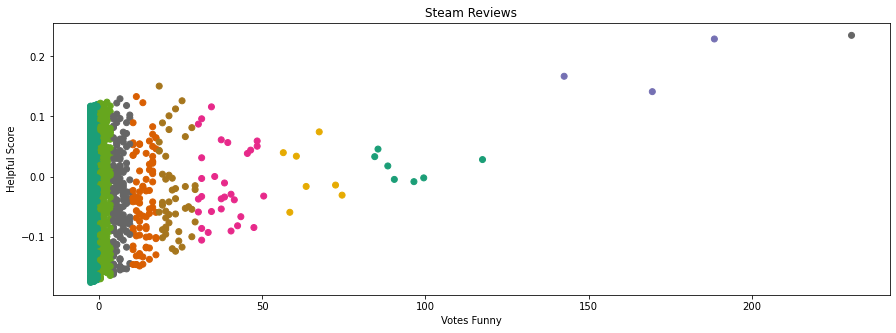

In [13]:
# Plot the Clusters
plt.figure(figsize=(15,5))
plt.scatter(pca_df.PC1, pca_df.PC2, c=pred, cmap = 'Dark2')
# Set title of the plot 
plt.title('Steam Reviews')
# Set x-axis label
plt.xlabel('Votes Funny')
# Set y-axis label
plt.ylabel('Helpful Score')
# Display the plot
plt.show()